In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
sys.path.insert(0, '/home/er647/projects/feature-wise-active-learning')
sys.path.insert(0, '/home/er647/projects/feature-wise-active-learning/src')
sys.path.insert(0, '/home/er647/projects/feature-wise-active-learning/notebooks')

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import datetime
from utils import *
# from _utils import filter_df_on_conditions, make_subplots
import seaborn as sns
from functools import partial

In [6]:
datetime.datetime.now(datetime.timezone.utc).isoformat()

'2024-02-13T15:43:29.588615+00:00'

In [7]:
# wandb.init(project="fwal",entity="evangeorgerex")
api = wandb.Api(timeout=60) #, entity='evangeorgerex')

In [9]:
# Define the project and sweep ID
entity = "evangeorgerex"
project_name = "fwal"
sweep_id = "o5jr0yrr"

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project_name}/{sweep_id}")

# Iterate over runs in the sweep
# for run in sweep.runs:
#     print(f"Run ID: {run.id}, Run Name: {run.name}, Run State: {run.state}")

    # You can also access other details of the run
    # For example, to get the config of each run:
    # print(run.config)

    # And to get summary metrics of each run:
    # print(run.summary)
print(len(sweep.runs))


9


In [10]:
runs_df = transforms_runs_into_dataframe(sweep.runs)
print(runs_df.shape)

(9, 184)


In [11]:
runs_df['best_mask_parameters'].head()

0    [0.013629755936563017, -0.6477029323577881, 0....
1    [0.2183457463979721, 0.003953967243432999, -0....
2    [0.2463814318180084, -0.06792446225881577, 0.0...
3    [-0.41347599029541016, -1.3477303981781006, 0....
4    [0.2183457463979721, 0.003953967243432999, -0....
Name: best_mask_parameters, dtype: object

In [12]:
# Convert the list in each row to a separate DataFrame
list_df = pd.DataFrame(runs_df['best_mask_parameters'].tolist())

list_df.columns = [f'best_mask_param_{i}' for i in range(len(list_df.columns))]

# Concatenate the new DataFrame with the original DataFrame
runs_df = pd.concat([runs_df, list_df], axis=1)



In [24]:
runs_df[[
    # 'dataset',
    'best_mask',
    'seed_model_init',
    'metric_model_selection',
    'bestmodel_test/balanced_accuracy',
    'bestmodel/step',
    'trainer/global_step'
    ]]

,best_mask,seed_model_init,metric_model_selection,bestmodel_test/balanced_accuracy,bestmodel/step,trainer/global_step
0,10100,2,balanced_accuracy,0.978557,276,966
1,11010,1,balanced_accuracy,0.956505,92,782
2,10100,0,balanced_accuracy,0.954889,92,782
3,00100,2,total_loss,0.884806,874,1564
4,11010,1,total_loss,0.956505,92,782
5,10100,0,total_loss,0.954889,92,782
6,11110,2,cross_entropy_loss,0.981087,46,736
7,11010,1,cross_entropy_loss,0.956505,92,782
8,10100,0,cross_entropy_loss,0.954889,92,782


In [14]:
runs_df.groupby([
    # 'dataset',
    'best_mask'
    ]).agg({
    'bestmodel_test/balanced_accuracy': 'mean',
    'bestmodel_test/cross_entropy_loss': 'mean',
    'bestmodel_test/reconstruction_loss': 'mean',
    'bestmodel_test/sparsity_loss': 'mean',
    # 'sparsity_loss': 'mean',
    # 'sparsity_regularizer_hyperparam': 'mean'
})

,bestmodel_test/balanced_accuracy,bestmodel_test/cross_entropy_loss,bestmodel_test/reconstruction_loss,bestmodel_test/sparsity_loss
best_mask,,,,
00100,0.884806,0.217225,0.245481,1.466723
10100,0.960806,0.122736,0.038136,2.169428
11010,0.956505,0.104835,0.027199,2.262948
11110,0.981087,0.046389,0.007439,2.370922


In [ ]:
transformed_columns = [col for col in runs_df.columns if '_transformed' in col]

# Sum the values across these columns for each row
runs_df['sparsity_loss'] = runs_df[transformed_columns].sum(axis=1)


In [ ]:
runs_df[runs_df['mask_type']=='gumbel_softmax']['sparsity_loss'].value_counts()

sparsity_loss
1.0    12
0.0     3
Name: count, dtype: int64

In [13]:
gumbel_df = runs_df[runs_df['mask_type']=='gumbel_softmax'].copy()

In [14]:
gumbel_df['best_mask_param_10_transformed'].isna().sum()


6

In [15]:
# Columns to convert to int
transformed_columns = [col for col in gumbel_df.columns if '_transformed' in col]

# Convert each column to int
for col in transformed_columns:
    gumbel_df[col] = pd.to_numeric(gumbel_df[col], errors='coerce').astype('Int64')


In [16]:
# Columns to concatenate
transformed_columns = [col for col in gumbel_df.columns if '_transformed' in col]

# Concatenate the values as strings
gumbel_df['mask'] = gumbel_df.apply(lambda row: ''.join(str(row[col]) if not pd.isna(row[col]) else '' for col in transformed_columns), axis=1)


In [24]:
gumbel_df['valid/balanced_accuracy']

0     0.933191
1     0.707213
2     0.854499
3     0.669965
4     0.682967
5     0.671700
6     0.615076
7     0.629889
8     0.641466
9     0.850500
10    0.804500
11    0.850000
12    0.899500
13    0.906000
14    0.898000
Name: valid/balanced_accuracy, dtype: float64

In [25]:
gumbel_df['bestmodel_valid/balanced_accuracy']


0     0.934952
1     0.630114
2     0.918377
3     0.669684
4     0.666142
5     0.666237
6     0.619437
7     0.615477
8     0.614942
9     0.874625
10    0.897625
11    0.881375
12    0.855000
13    0.866625
14    0.855125
Name: bestmodel_valid/balanced_accuracy, dtype: float64

In [26]:
gumbel_df['id']


0     dr0p5zu6
1     y9042ap8
2     6ggf0h6a
3     4xvumqoa
4     u4ccpqts
5     zv8166dr
6     qeoykxj1
7     t836m1ql
8     w704rgvl
9     15he0bmw
10    eysbro4k
11    ahqxe2l4
12    ghwl8ycp
13    2toq3d8b
14    geuykwme
Name: id, dtype: object

In [34]:
artifact_name='15he0bmw'
artifact = api.artifact(f'{entity}/{project_name}/{artifact_name}:v0', type='model')
artifact_dir = artifact.download()


CommError: It appears that you do not have permission to access the requested resource. Please reach out to the project owner to grant you access. If you have the correct permissions, verify that there are no issues with your networking setup.(Error 404: Not Found)

In [ ]:
# Assuming the model weights are saved in a file named 'model-best.pt' in the artifact
model_path = f'{artifact_dir}/model-best.pt'

In [22]:
gumbel_df.columns

Index(['name', 'id', 'valid/F1_weighted', 'train/sparsity_loss',
       'trainer/global_step', 'bestmodel_valid/AUROC_weighted', 'epoch',
       'bestmodel/step', 'valid/sparsity_loss', 'best_mask_parameters',
       ...
       'best_mask_param_3_transformed', 'best_mask_param_4_transformed',
       'best_mask_param_5_transformed', 'best_mask_param_6_transformed',
       'best_mask_param_7_transformed', 'best_mask_param_8_transformed',
       'best_mask_param_9_transformed', 'best_mask_param_10_transformed',
       'sparsity_loss', 'mask'],
      dtype='object', length=187)

In [36]:
# df_reset = 
# gumbel_df[~gumbel_df['dataset'].isin(['exponential_interaction_synth','summed_squares_exponential_synth','trigonometric_polynomial_synth'])]
gumbel_df.groupby([
    'dataset',
    # 'mask'
    ]).agg({
    'bestmodel_test/balanced_accuracy': 'mean',
    'bestmodel_test/cross_entropy_loss': 'mean',
    'bestmodel_test/reconstruction_loss': 'mean',
    'bestmodel_test/sparsity_loss': 'mean',
    # 'sparsity_loss': 'mean',
    # 'sparsity_regularizer_hyperparam': 'mean'
})

,bestmodel_test/balanced_accuracy,bestmodel_test/cross_entropy_loss,bestmodel_test/reconstruction_loss,bestmodel_test/sparsity_loss
dataset,,,,
exponential_interaction_synth,0.620816,0.626443,0.477462,3.422421
simple_linear_synth,0.883000,0.253744,0.275443,2.071611
simple_trig_synth,0.864767,0.270512,0.302699,1.724638
summed_squares_exponential_synth,0.667478,0.583697,0.347106,3.985081
trigonometric_polynomial_synth,0.831040,0.114664,0.355580,3.288576


In [118]:
df_reset = df_reset.reset_index()

# Melt the DataFrame
df_melted = df_reset.melt(id_vars=['dataset', 'mask'], 
                            value_vars=['valid/cross_entropy_loss', 'valid/reconstruction_loss', 'sparsity_loss'],
                            var_name='loss_type', value_name='loss_value')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='mask', y='loss_value', hue='loss_type', ci=None)
plt.yscale('log')  # Use logarithmic scale due to large range of values
plt.title("Losses by Mask and Dataset")
plt.xlabel("Mask")
plt.ylabel("Loss Value")
plt.legend(title='Loss Type')
plt.show()

ValueError: cannot insert level_0, already exists

In [71]:
gumbel_df['best_mask_param_2_transformed']

0      0
1      0
2      0
3      0
4      1
      ..
130    0
131    0
132    0
133    1
134    1
Name: best_mask_param_2_transformed, Length: 75, dtype: int32

In [30]:
runs_df['valid/sparsity_loss'][0]

1937500032.0

In [34]:
runs_df_copy = runs_df.copy()

In [35]:
runs_df = runs_df[runs_df['sparsity_regularizer_hyperparam']<1000000000]

In [36]:
runs_df['sparsity_regularizer_hyperparam'].value_counts()


1000000    30
1000       30
1          30
0          30
Name: sparsity_regularizer_hyperparam, dtype: int64

Text(0, 0.5, 'Best Model Valid Cross Entropy Loss')

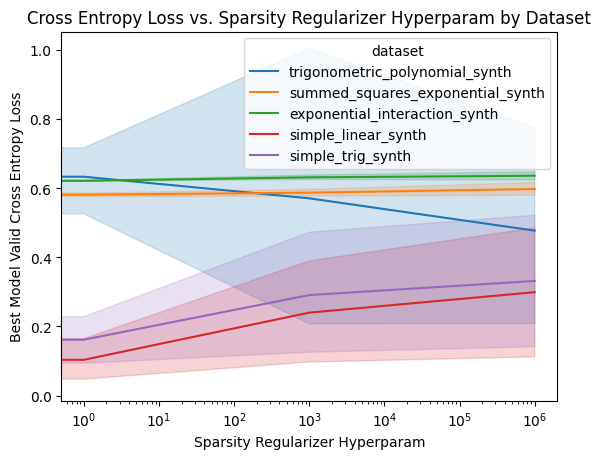

In [37]:
sns.lineplot(data=runs_df, x='sparsity_regularizer_hyperparam', y='valid/cross_entropy_loss', hue='dataset')

plt.xscale('log')


# Customize the plot
plt.title("Cross Entropy Loss vs. Sparsity Regularizer Hyperparam by Dataset")
plt.xlabel("Sparsity Regularizer Hyperparam")
plt.ylabel("Best Model Valid Cross Entropy Loss")

Text(0, 0.5, 'Best Model Valid Reconstruction Loss')

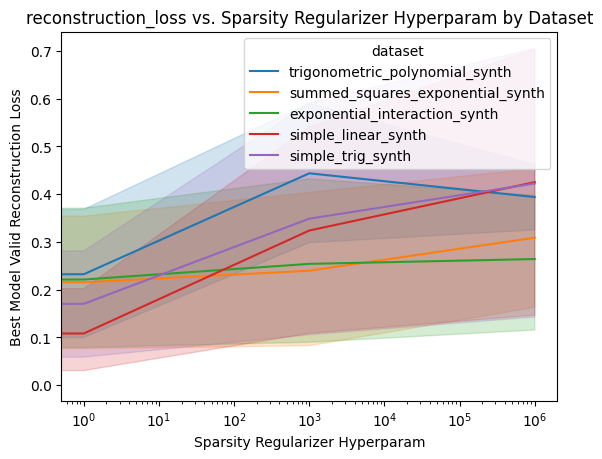

In [38]:
sns.lineplot(data=runs_df, x='sparsity_regularizer_hyperparam', y='valid/reconstruction_loss', hue='dataset')

plt.xscale('log')


# Customize the plot
plt.title("reconstruction_loss vs. Sparsity Regularizer Hyperparam by Dataset")
plt.xlabel("Sparsity Regularizer Hyperparam")
plt.ylabel("Best Model Valid Reconstruction Loss")

Text(0, 0.5, 'Best mask L1')

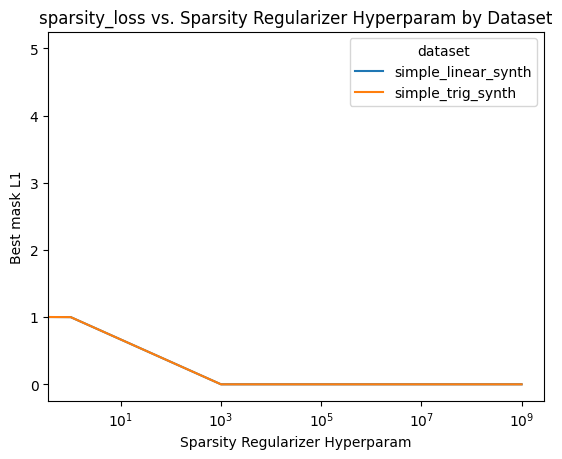

In [107]:
sns.lineplot(data=gumbel_df[~gumbel_df['dataset'].isin(['exponential_interaction_synth','summed_squares_exponential_synth','trigonometric_polynomial_synth'])], x='sparsity_regularizer_hyperparam', y='sparsity_loss', hue='dataset')

plt.xscale('log')


# Customize the plot
plt.title("sparsity_loss vs. Sparsity Regularizer Hyperparam by Dataset")
plt.xlabel("Sparsity Regularizer Hyperparam")
plt.ylabel("Best mask L1")

In [17]:
runs_df['dataset'].value_counts()

trigonometric_polynomial_synth      30
summed_squares_exponential_synth    30
exponential_interaction_synth       30
simple_linear_synth                 30
simple_trig_synth                   30
Name: dataset, dtype: int64

In [ ]:
runs_df['bestmodel_valid/cross_entropy_loss']

In [19]:
runs_df['best_mask_parameters'].head()

0    [-0.8734390139579773, -1.003793478012085, -0.9...
1    [-0.906295895576477, -1.0336754322052002, -1.0...
2    [-0.9349806308746338, -1.059366226196289, -1.0...
3    [-0.6455142498016357, -0.732622504234314, -0.7...
4    [0.98233300447464, 0.8575429916381836, 0.94713...
Name: best_mask_parameters, dtype: object

In [7]:
pd.set_option('display.max_columns', None)
runs_df[
    ['id',
    #  'lr','gamma',
     'mask_type',
     'sparsity_regularizer_hyperparam',
    #  'bestmodel_valid/balanced_accuracy','bestmodel_valid/reconstruction_loss','bestmodel_valid/sparsity_loss',
     'best_mask_parameters']
    ]

,id,mask_type,sparsity_regularizer_hyperparam,best_mask_parameters
0,ikhki7dh,probabilistic,1000.0,"[0.3366183936595917, 0.1287771463394165, 0.234..."
1,aqe3jozq,probabilistic,1000.0,"[0.3365437388420105, 0.12873981893062592, 0.23..."
2,wiy9fpyv,probabilistic,1000.0,"[0.3365899324417114, 0.12876291573047638, 0.23..."
3,ek3m1i82,probabilistic,1000.0,"[0.3365899324417114, 0.12876291573047638, 0.23..."
4,begatpu9,probabilistic,1000.0,"[0.33658725023269653, 0.12876157462596893, 0.2..."
...,...,...,...,...
195,zz8x59c5,sigmoid,0.0,"[0.3403615653514862, 0.24742859601974487, 0.38..."
196,kv4burnd,sigmoid,0.0,"[0.3523191809654236, 0.2648531198501587, 0.382..."
197,99wqap9g,sigmoid,0.0,"[0.37576863169670105, 0.2500225603580475, 0.36..."
198,k5g0jq4i,sigmoid,0.0,"[0.3704529404640198, 0.2280469834804535, 0.353..."


In [16]:
# Splitting the array in 'best_mask_parameters' into individual columns
parameters_df = pd.DataFrame(runs_df['best_mask_parameters'].to_list(), columns=[f'parameter_{i}' for i in range(1, 6)])
parameters_df = pd.concat([runs_df, parameters_df], axis=1)



In [23]:
df = parameters_df
columns = [f'parameter_{i}' for i in range(1, 6)]
columns.extend(['mask_type','dataset',
                # 'repeat_id','test_split',
                'bestmodel_valid/balanced_accuracy','bestmodel_valid/reconstruction_loss','bestmodel_valid/sparsity_loss'])
df = df[df['sparsity_regularizer_hyperparam']==1]
df[columns].groupby(['mask_type','dataset']).agg('mean')

parameter_1  parameter_2  parameter_3  \
mask_type     dataset                                                    
probabilistic simple_synth          0.336579     0.128757     0.234387   
              very_simple_synth     0.336576     0.128756     0.234386   
sigmoid       simple_synth         -1.943436    -1.864626    -2.083116   
              very_simple_synth    -2.313782    -2.586958    -2.585783   

                                 parameter_4  parameter_5  \
mask_type     dataset                                       
probabilistic simple_synth          0.230258    -1.122440   
              very_simple_synth     0.230256    -1.122429   
sigmoid       simple_synth         -2.043080    -3.346113   
              very_simple_synth    -2.505562    -3.927479   

                                 bestmodel_valid/balanced_accuracy  \
mask_type     dataset                                                
probabilistic simple_synth                                0.914035   
              very_simple_synth                           0.930208   
sigmoid       simple_synth                                0.980435   
              very_simple_synth                           0.995750   

                                 bestmodel_valid/reconstruction_loss  \
mask_type     dataset                                                  
probabilistic simple_synth                                  0.183964   
              very_simple_synth                             0.172642   
sigmoid       simple_synth                                  0.009447   
              very_simple_synth                             0.001652   

                                 bestmodel_valid/sparsity_loss  
mask_type     dataset                                           
probabilistic simple_synth                            2.518277  
              very_simple_synth                       2.496519  
sigmoid       simple_synth                            0.943999  
              very_simple_synth                       0.413094

In [26]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
sigmoid_df = df
sigmoid_df[["parameter_1", "parameter_2", "parameter_3", "parameter_4", "parameter_5"]] = sigmoid_df[["parameter_1", "parameter_2", "parameter_3", "parameter_4", "parameter_5"]].apply(sigmoid)
sigmoid_df[columns].groupby(['mask_type','dataset']).agg('mean')

/tmp/ipykernel_4138728/3650782278.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmoid_df[["parameter_1", "parameter_2", "parameter_3", "parameter_4", "parameter_5"]] = sigmoid_df[["parameter_1", "parameter_2", "parameter_3", "parameter_4", "parameter_5"]].apply(sigmoid)
/tmp/ipykernel_4138728/3650782278.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmoid_df[["parameter_1", "parameter_2", "parameter_3", "parameter_4", "parameter_5"]] = sigmoid_df[["parameter_1", "parameter_2", "parameter_3", 

parameter_1  parameter_2  parameter_3  \
mask_type     dataset                                                    
probabilistic simple_synth          0.583359     0.532145     0.558330   
              very_simple_synth     0.583359     0.532145     0.558330   
sigmoid       simple_synth          0.126166     0.134857     0.111661   
              very_simple_synth     0.090106     0.070077     0.070227   

                                 parameter_4  parameter_5  \
mask_type     dataset                                       
probabilistic simple_synth          0.557311     0.245559   
              very_simple_synth     0.557311     0.245561   
sigmoid       simple_synth          0.115670     0.034357   
              very_simple_synth     0.075567     0.019369   

                                 bestmodel_valid/balanced_accuracy  \
mask_type     dataset                                                
probabilistic simple_synth                                0.914035   
              very_simple_synth                           0.930208   
sigmoid       simple_synth                                0.980435   
              very_simple_synth                           0.995750   

                                 bestmodel_valid/reconstruction_loss  \
mask_type     dataset                                                  
probabilistic simple_synth                                  0.183964   
              very_simple_synth                             0.172642   
sigmoid       simple_synth                                  0.009447   
              very_simple_synth                             0.001652   

                                 bestmodel_valid/sparsity_loss  
mask_type     dataset                                           
probabilistic simple_synth                            2.518277  
              very_simple_synth                       2.496519  
sigmoid       simple_synth                            0.943999  
              very_simple_synth                       0.413094

In [ ]:
### Plot
pd.options.display.float_format = '{:,.2f}'.format

grouped = runs_df.groupby(['dataset', 'embedding_type'])
g1 = grouped.agg({'bestmodel_train/balanced_accuracy': ['mean', 'std']})*100
g2 = grouped.agg({'bestmodel_test/balanced_accuracy': ['mean', 'std']})*100
res = pd.concat([g1, g2], axis=1).round(decimals=2)
res

In [ ]:
# file_name = 'test'
# res.to_csv(f'/home/er647/projects/feature-wise-active-learning/compute_results/csv/{file_name}.csv')
# res.to_excel(f'/home/er647/projects/feature-wise-active-learning/compute_results/csv/{file_name}.xlsx')